<center><h1 style:"text-align:center;">Formulación 1</h1></center>
<center><h3>Relé 1</h3></center>

### 1. Imports

In [107]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Métricas
from torchmetrics.functional.classification import binary_stat_scores

# Visualizar datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Progress bar
from tqdm import tqdm

# Acceder al sistema operativo
import os
import glob
import shutil
import random


### 2. Model Parameters

In [108]:
# LSTM parameters
hidden_dim = 20
n_signals = 3
N = 64

# _batch_size => m in figure 1.
train_batch_size = 64
dev_batch_size = 16
test_batch_size = 16

# Classification type (binary)
tagset_size = 1

# Set
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


### 3. Model Creation

##### 3.1. FaultDetector Class Creation

In [109]:
# Model Creation


class FaultDetector(nn.Module):
    """Information about FaultDetector"""

    def __init__(self, n_signals, hidden_dim, tagset_size):
        super(FaultDetector, self).__init__()
        self.lstm = nn.LSTM(n_signals, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


##### 3.2. Model Instance Initialization

In [110]:
model = FaultDetector(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# Learning rate decay (optional)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer, gamma=decayRate
)

print(f"Model structure: {model}\n")

# Number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters: {params}")


Model structure: FaultDetector(
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

Number of parameters: 2021


### 4. Dataset Creation

##### 4.1. Dataset Class Creation

In [186]:
# from utils.signalload import CSV_pandas_path
# from utils.auxfunctions import moving_window
from utils_tesis.signalload import CSV_pandas_path
from utils_tesis.auxfunctions import moving_window
import numpy as np
from itertools import repeat


class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(
        self,
        dataset_dir,
        signal_names,
        max_window_idx=193,
        window_length=64,
        step=1,
        test=False,
    ):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx
        self.test = test
        self.signal_names = signal_names

        self.csv_list = glob.glob(f"{dataset_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.window_length = window_length
        self.step = step

    def __getitem__(self, index, data_plot=False):

        # sample_settings
        window_length = self.window_length
        step = self.step

        # Calculate window_idx and file name
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        signal_windows = (torch,)
        csv_name = os.path.basename(csv_full_path)
        signals_windows = np.empty((self.window_length, 0))
        for signal_name in self.signal_names:
            signal, t, _ = CSV_pandas_path(csv_full_path).load_data(signal_name)
            signal_windows, t_windows = list(
                map(moving_window, [signal, t], repeat(window_length), repeat(step))
            )

            # select window

            signal_window = signal_windows[window_idx]
            signal_window = np.expand_dims(signal_window, axis=1)
            t_window = t_windows[window_idx]

            signals_windows = np.append(signals_windows, signal_window, axis=1)
        # create labels
        if window_idx < 66:
            label = np.array([0])
        else:
            label = np.array([1])

        # For dataset visualization return following information
        signals_windows = torch.from_numpy(np.copy(signals_windows)).float()
        label = torch.from_numpy(label).float()
        if data_plot == True:
            return signals_windows.reshape(-1).numpy(), t_window
        if self.test == True:
            return signals_windows, t_window, label, csv_name, index, window_idx

        # For training only signals and labels are required

        return signals_windows, label

    def get_event(self, csv_idx):

        # Get indices
        idx_min = csv_idx * self.max_window_idx
        idx_max = ((csv_idx + 1) * self.max_window_idx) - 1

        # Get path of csv_index
        csv_full_path = self.csv_list[csv_idx]

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)

        # Load CSV, signal and create windows
        csv_name = os.path.basename(csv_full_path)
        signals = np.zeros((0,0))
        for idx, signal_name in enumerate(self.signal_names):
            signal, t, _ = CSV_pandas_path(csv_full_path).load_data(signal_name)
            signal = np.expand_dims(signal, axis=1)
            if idx == 0:
                signals = np.empty((len(signal), 0))
                print(len(signal))
                print(signals.shape)
            signals = np.append(signals, signal, axis=1)
        signal = signals
        return signal, t, idx_min, idx_max, csv_name

    def len_events(self):
        return self.csv_amount

    def __len__(self):
        return self.csv_amount * self.max_window_idx


##### 4.2. Database Directory Creation 

In [149]:
# Creating Dataset Folders

dataset_dir_full = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/fault_01/"
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R1/"

max_window_idx = 130
n_events = 54


def dataset_creator(source_path, target_path, signal_list=False):
    csv_list = glob.glob(f"{source_path}*.csv")
    if not os.path.isdir(target_path):
        print("creating")
        os.makedirs(target_path)
    else:
        file_list = glob.glob(f"{target_path}*.csv")
        for file in file_list:
            os.remove(file)
    csv_list = random.sample(csv_list, n_events)
    print(f"copying {len(csv_list)} files...")
    for csv in csv_list:
        source_path = csv
        target_path = target_path
        shutil.copy(source_path, target_path)
    print("finished")

    if signal_list == True:
        print("Available Relays (current):")
        CSV_pandas_path(csv_list[0]).relay_list()


# Crear los 3 Datasets para entrenar los relés individualmente
dataset_creator(dataset_dir_full, dataset_dir, signal_list=False)


copying 54 files...
finished


##### 4.3. Dataset and Dataloader Instances Creation

In [145]:
# Load Dataset
current_R1A = "I: X0023A-R1A"
current_R1B = "I: X0023B-R1B"
current_R1C = "I: X0023C-R1C"

voltage_R1A = "V: R1A"
voltage_R1B = "V: R1B"
voltage_R1C = "V: R1C"
signal_names = [current_R1A, current_R1B, current_R1C]

dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names
)
# dataset.get_events(0)
train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
# EL test set realmente es un dev set
# Como regla general, si es utilizado dentro del loop es un dev set.


In [102]:
# dataset = Form1Dataset(
#     dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names
# )
# # dataset.get_events(0)
# train_dataset, test_dataset = random_split(dataset, [0.95, 0.05])
# train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# iterator = iter(train_dataloader)
# signals, labels = next(iterator)
# print(signals.shape)
# print(labels.shape)

torch.Size([5, 64, 6])
torch.Size([5, 1])


In [ ]:
signal_idx = 0
plt.plot(signals[signal_idx, :, 0])
plt.plot(signals[signal_idx, :, 1])
plt.plot(signals[signal_idx, :, 2])
plt.show()
plt.plot(signals[signal_idx, :, 3])
plt.plot(signals[signal_idx, :, 4])
plt.plot(signals[signal_idx, :, 5])

print(labels[signal_idx].item())


### 5. Model Training


##### 5.1. Train / Test(dev) Loop Creation

In [114]:
# Create Training / Test / Validation Loops


# Training
def train(dataloader, model, loss_fn, optimizer, return_loss=False):
    size = len(dataloader.dataset)
    model.train()
    loss_list = []

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if return_loss == True:
            loss_list.append(loss.item())
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")

        if batch % 5 == 0:
            my_lr_scheduler.step()
    if return_loss == True:
        return loss_list


from torchmetrics.functional.classification import binary_stat_scores


def test_metrics(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):

            x, y = x.to(device), y.to(device)
            pred = model(x)

            conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    acc = (conf_matrix[0, 0] + conf_matrix[0, 2]) / conf_matrix[0, :-1].sum()
    correct /= size
    print(f"{correct*100:>0.1f}")
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if return_metrics == True:
        return conf_matrix, test_loss


##### 5.2. Training the model

In [115]:
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))

epochs = 1

for epoch in range(epochs):

    print(f"Epoch {epoch+1}\n--------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, return_loss=True)
    # accuracy, _ = test(test_dataloader, model, loss_fn, return_metrics=True)
    conf_matrix, _ = test_metrics(test_dataloader, model, loss_fn, return_metrics=True)
print(conf_matrix)


Epoch 1
--------------------------------
loss: 0.723797 [    0/ 6669]
loss: 0.642781 [  128/ 6669]
loss: 0.615875 [  256/ 6669]
loss: 0.612191 [  384/ 6669]
loss: 0.554017 [  512/ 6669]
loss: 0.521725 [  640/ 6669]
loss: 0.544552 [  768/ 6669]
loss: 0.536171 [  896/ 6669]
loss: 0.494395 [ 1024/ 6669]
loss: 0.458815 [ 1152/ 6669]
loss: 0.395688 [ 1280/ 6669]
loss: 0.414593 [ 1408/ 6669]
loss: 0.395301 [ 1536/ 6669]
loss: 0.327625 [ 1664/ 6669]
loss: 0.305073 [ 1792/ 6669]
loss: 0.293847 [ 1920/ 6669]
loss: 0.266395 [ 2048/ 6669]
loss: 0.226953 [ 2176/ 6669]
loss: 0.226632 [ 2304/ 6669]
loss: 0.207816 [ 2432/ 6669]
loss: 0.172063 [ 2560/ 6669]
loss: 0.183025 [ 2688/ 6669]
loss: 0.188376 [ 2816/ 6669]
loss: 0.154543 [ 2944/ 6669]
loss: 0.161837 [ 3072/ 6669]
loss: 0.162413 [ 3200/ 6669]
loss: 0.190581 [ 3328/ 6669]
loss: 0.087684 [ 3456/ 6669]
loss: 0.151439 [ 3584/ 6669]
loss: 0.156211 [ 3712/ 6669]
loss: 0.123660 [ 3840/ 6669]
loss: 0.103841 [ 3968/ 6669]
loss: 0.073751 [ 4096/ 6669]
lo

100%|██████████| 22/22 [01:40<00:00,  4.56s/it]

96.9
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.115059 

tensor([[172,   0, 168,  11, 183]])


In [116]:
def conf_matrix_metrics(conf_matrix: torch.LongTensor) -> dict:
    """
    Returns dictionary with metrics from a confusion matrix.

            Parameters:
                    conf_matrix (torch.Tensor): confusion matrix of dimension (1, 5)
                        [TP, FP, TN, FN, TP + FN]

            Returns:
                    metrics (dict): dictionary with following metrics:
                        metrics["TOTAL"] -> total amount of samples.
                        metrics["TPR"]   -> True Positive Rate,  sensibility, recall, hit-rate.
                        metrics["FPR"]   -> False Positive Rate, Fallout.
                        metrics["TNR"]   -> True Negative Rate,  specificity, selectivity
                        metrics["ACC"]   -> Accuracy.
                        metrics["PPV"]   -> Positive Predictive Value, Precision.
    """
    if conf_matrix.shape == (5,):
        conf_matrix = np.expand_dims(conf_matrix, axis=0)

    metrics = {}
    TP = int(conf_matrix[0, 0].item())
    FP = int(conf_matrix[0, 1].item())
    TN = int(conf_matrix[0, 2].item())
    FN = int(conf_matrix[0, 3].item())
    metrics["TP"] = TP
    metrics["FP"] = FP
    metrics["TN"] = TN
    metrics["FN"] = FN
    P = TP + FN
    N = TN + FP
    TOTAL = TP + FP + TN + FN
    metrics["TOTAL"] = TOTAL
    metrics["TPR"] = TP / (TP + FN)
    metrics["FPR"] = FP / (FP + TN)
    metrics["TNR"] = TN / (FP + TN)
    metrics["ACC"] = (TP + TN) / (TOTAL)
    try:
        metrics["PPV"] = TP / (TP + FP)
    except ZeroDivisionError:
        print("No se puede obtener PPV, división por cero")
    return metrics


metrics = conf_matrix_metrics(conf_matrix)
print(round(metrics["ACC"] * 100, 1))
print(conf_matrix)


96.9
tensor([[172,   0, 168,  11, 183]])


##### 5.3. Training loss visualization

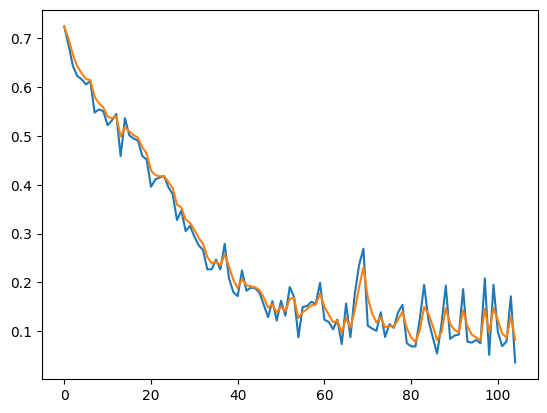

In [117]:
try:
    mini_batch_list = [index for index, _ in enumerate(train_loss)]
    train_loss_ewm = pd.DataFrame(train_loss).ewm(com=0.95).mean()
    plt.plot(mini_batch_list, train_loss, mini_batch_list, train_loss_ewm)
except NameError:
    print("Error! Run train loop")


##### 5.4. Saving the Model

In [128]:
# # Save the Model
torch.save(model.state_dict(), './models/LSTMHarmonic_weights_R1Currents.pth')


### 6. Results Visualization


#### 6.1. Confussion Matrix Results Table Function

In [119]:
# Data visualization (CPU)


def confusion_matrix_labels(pred_label, true_label):
    label = ""
    if int(pred_label) == int(true_label):
        label += "T"
    else:
        label += "F"
    if pred_label == 1:
        label += "P"
    else:
        label += "N"
    return label


confusion_matrix_pandas = np.vectorize(confusion_matrix_labels)


def confusion_matrix(
    preds: torch.FloatTensor, labels: torch.FloatTensor
) -> pd.DataFrame:
    preds = preds.detach()
    labels = labels.detach()
    data = {
        "Pred probability": torch.reshape(preds, (-1,)).cpu().numpy(),
        "Pred label": torch.reshape(torch.round(preds), (-1,)).int().cpu().numpy(),
        "True label": torch.reshape(labels, (-1,)).int().cpu().numpy(),
    }
    df = pd.DataFrame(data)
    df["Result"] = confusion_matrix_pandas(df["Pred label"], df["True label"])
    return df


##### 6.2. Plotly Plot

In [122]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fs = 3840
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, csv_name, index, window_idx = next(dataiter)
print(len(csv_name))
print(window_idx.shape)
print(labels.shape)

print(labels.type())
x = model(signal_windows[0:9].to(device))
# x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[0:9])
print(type(df))
print(df)

# figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
fig = make_subplots(rows=rows, cols=cols)

label_to_text = {
    "0": "No Fault",
    "1": "Fault",
}

for i in range(0, cols * rows):

    col = i % cols
    row = i // cols
    label = label_to_text[str(int(labels[i, 0].item()))]
    win_idx = str(window_idx[i].item())
    fig.add_trace(
        go.Scatter(
            name=f"{label} - {win_idx} - {csv_name[i]}",
            x=t_windows[i, :],
            y=signal_windows[i, :, 0],
            marker_color="black",
        ),
        row=row + 1,
        col=col + 1,
    )

fig.update_layout(
    height=700,
    width=900,
    title_text="Figuras",
    margin={"b": 20, "t": 40, "l": 20, "r": 30},
    plot_bgcolor="rgba(0,0,0,0)",
    # paper_bgcolor="whitesmoke",
)
fig.show()


c:\Users\aherrada\Documents\Git\Pytorch\env\lib\site-packages\torch\utils\data\_utils\collate.py:172: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)



64
torch.Size([64])
torch.Size([64, 1])
torch.FloatTensor
<class 'pandas.core.frame.DataFrame'>
   Pred probability  Pred label  True label Result
0          0.072259           0           0     TN
1          0.014200           0           0     TN
2          0.974816           1           1     TP
3          0.030305           0           0     TN
4          0.026585           0           0     TN
5          0.044918           0           0     TN
6          0.037303           0           0     TN
7          0.022272           0           0     TN
8          0.988926           1           1     TP


##### 6.3. Matplotlib Plots

   Pred probability  Pred label  True label Result
0          0.957137           1           1     TP
1          0.991155           1           1     TP
2          0.021416           0           0     TN
3          0.027745           0           0     TN
4          0.953456           1           1     TP
5          0.034782           0           0     TN
6          0.044374           0           0     TN
7          0.976099           1           1     TP
8          0.972686           1           1     TP


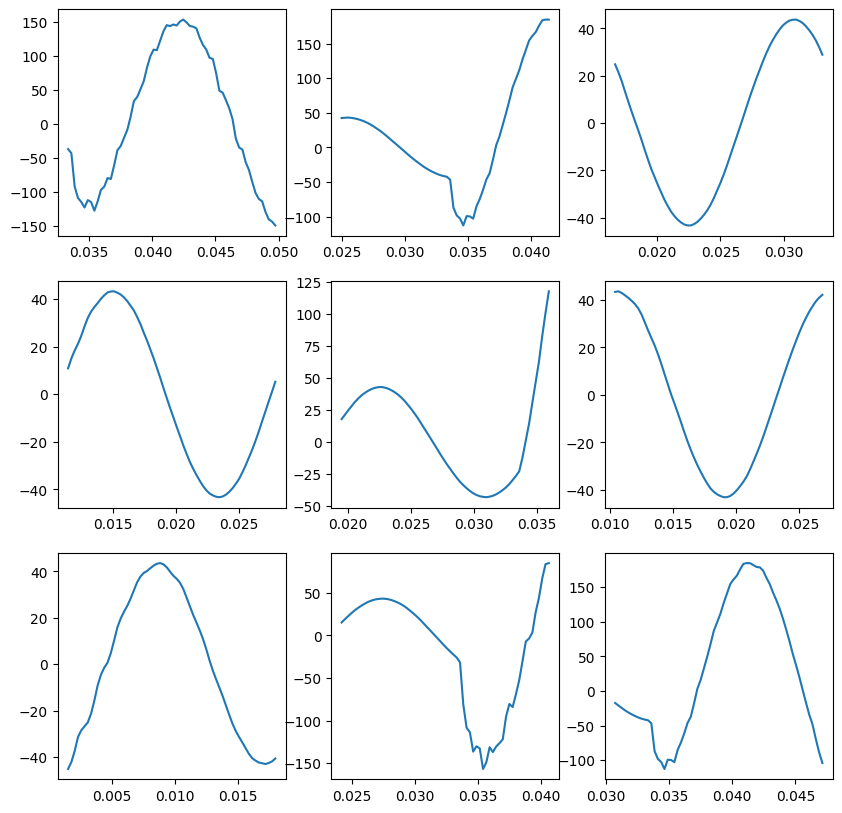

In [125]:
dataset_plot = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names, test=True
)
plot_dataloader = DataLoader(dataset_plot, batch_size=train_batch_size, shuffle=True)

dataiter = iter(plot_dataloader)
signal_windows, t_windows, labels, *_ = next(dataiter)
fs = 3840

x = model(signal_windows[1:10].to(device))
x = x.detach()

# Crear Matriz de confusión
df = confusion_matrix(x, labels[1:10])
print(df)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t_windows[i, :], signal_windows[i, :, 0])


### 7. Data Exploration

##### 7.1. Auxiliar Functions

In [131]:
def signal_exploration(idx: int, dataset, model, plot_signal: bool = True):
    signal, t, idx_min, idx_max, csv_name = dataset.get_event(idx)
    model.eval()
    if plot_signal == True:
        plt.plot(t, signal)
        plt.show()
    conf_matrix = torch.zeros(1, 5, dtype=torch.int64).to(device)
    preds = torch.empty((0, 1)).to(device)
    labels = torch.empty((0, 1)).to(device)
    for i in range(idx_min, idx_max + 1):
        signal, y = dataset.__getitem__(i)
        y = torch.unsqueeze(y, 0).to(device)
        signal = torch.unsqueeze(signal, 0).to(device)
        pred = model(signal)
        preds = torch.cat((preds, pred), 0)
        labels = torch.cat((labels, y), 0)
        conf_matrix = conf_matrix.add(binary_stat_scores(pred, y))
    df = confusion_matrix(preds, labels)
    df.insert(loc=0, column="event_idx", value=np.repeat(idx, idx_max - idx_min + 1))
    # df.insert(loc=0, column="window_idx", value=df.index)
    # df.insert(loc=0, column="indices", value=idxs)

    return df, conf_matrix


def plot_confusion_matrix(metrics):
    z = [[metrics["TP"], metrics["FN"]], [metrics["FP"], metrics["TN"]]]
    fig = px.imshow(
        z,
        text_auto=True,
        template="seaborn",
        labels=dict(x="Predicted Label", y="Real Label", color="Predictions"),
        x=["Positive", "Negative"],
        y=["Positive", "Negative"],
        width=400,
        height=300,
    )
    fig.show()


def print_metrics(metrics):
    print(f"{'Total windows:':.<30}{metrics['TOTAL']:4}")
    print(f"{'True Positives:':.<30}{metrics['TP']:4}")
    print(f"{'False Positives:':.<30}{metrics['FP']:4}")
    print(f"{'True Negatives:':.<30}{metrics['TN']:4}")
    print(f"{'False Negatives:':.<30}{metrics['FN']:4}")
    print(f"{'Accuracy:':.<30}{metrics['ACC']*100:>6.1f}%")
    print(f"{'True Positive Rate:':.<30}{metrics['TPR']*100:>6.1f}%") 
    print(f"{'False Positive Rate:':.<30}{metrics['FPR']*100:>6.1f}%") 
    print(f"{'True Negative Rate:':.<30}{metrics['TNR']*100:>6.1f}%") 
    try:
        print(f"{'Positive Predictive Value:':.<30}{metrics['PPV']*100:>6.1f}%")
    except KeyError:
        print(f"PPV divided by 0. No positive class predicted")
    # metrics["PPV"]


##### 7.2. Data Exploration

In [187]:
# Seleccionar pesos de modelo
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R3_934.pth'))
# model.load_state_dict(torch.load("./models/LSTMHarmonic_weights_R1_996.pth"))
# model.load_state_dict(torch.load('./models/LSTMHarmonic_weights_R2_978.pth'))

# Select Signal Name
# signal_name = "I: X0023A-R1A"
# signal_name = "I: X0004A-R2A"
# signal_name = "I: X0071A-R3A"

# Create Dataset
dataset = Form1Dataset(
    dataset_dir, max_window_idx=max_window_idx, signal_names=signal_names
)




##### 7.4. Plot individual windows

##### 7.5. Whole Dataset Exploration

In [178]:
# Create Dataframe with information about data
print(dataset.len_events())
conf_matrix = torch.zeros(0, 5, dtype=torch.int64).to(device)
for idx in tqdm(range(dataset.len_events())):
# for idx in tqdm(range()):
    df, CM = signal_exploration(idx, dataset, model, plot_signal=False)
    conf_matrix = torch.cat((conf_matrix, CM))
    if idx == 0:
        dataset_df = df
    else:
        dataset_df = pd.concat([dataset_df, df])

dataset_df = dataset_df.reset_index()
dataset_df = dataset_df.rename(columns={'index': 'window idx'})
conf_matrix_total = np.sum(conf_matrix.cpu().numpy(), axis=0)


# # # Load Dataframe
# def load_df(i):
#     dataset_df = pd.read_parquet(f"parquet_data/ModelR{i}_R{i}_df.parquet")
#     conf_matrix_df = pd.read_parquet(f"parquet_data/ModelR{i}_R{i}_CM_df.parquet")
#     conf_matrix = np.load(f"parquet_data/ModelR{i}_R{i}_CM.npy", allow_pickle=False)
#     return dataset_df, conf_matrix_df, conf_matrix

# dataset_df, conf_matrix_df, conf_matrix = load_df(1)
# conf_matrix_total = np.sum(conf_matrix, axis=0)
# metrics = conf_matrix_metrics(conf_matrix_total)


54


  0%|          | 0/54 [00:00<?, ?it/s]

256
(256, 0)


  2%|▏         | 1/54 [00:21<19:13, 21.77s/it]

256
(256, 0)


  4%|▎         | 2/54 [00:42<18:09, 20.94s/it]

256
(256, 0)


  6%|▌         | 3/54 [01:03<17:46, 20.91s/it]

256
(256, 0)


  7%|▋         | 4/54 [01:24<17:31, 21.02s/it]

256
(256, 0)


  9%|▉         | 5/54 [01:44<16:53, 20.68s/it]

256
(256, 0)


 11%|█         | 6/54 [02:05<16:43, 20.90s/it]

256
(256, 0)


 13%|█▎        | 7/54 [02:25<16:13, 20.72s/it]

256
(256, 0)


 15%|█▍        | 8/54 [02:45<15:39, 20.42s/it]

256
(256, 0)


 17%|█▋        | 9/54 [03:05<15:08, 20.20s/it]

256
(256, 0)


 19%|█▊        | 10/54 [03:25<14:53, 20.30s/it]

256
(256, 0)


 20%|██        | 11/54 [03:48<14:58, 20.89s/it]

256
(256, 0)


 22%|██▏       | 12/54 [04:08<14:34, 20.83s/it]

256
(256, 0)


 24%|██▍       | 13/54 [04:29<14:12, 20.79s/it]

256
(256, 0)


 26%|██▌       | 14/54 [04:49<13:44, 20.62s/it]

256
(256, 0)


 28%|██▊       | 15/54 [05:11<13:33, 20.87s/it]

256
(256, 0)


 30%|██▉       | 16/54 [05:32<13:15, 20.92s/it]

256
(256, 0)


 31%|███▏      | 17/54 [05:52<12:47, 20.76s/it]

256
(256, 0)


 33%|███▎      | 18/54 [06:13<12:27, 20.75s/it]

256
(256, 0)


 35%|███▌      | 19/54 [06:33<12:01, 20.62s/it]

256
(256, 0)


 37%|███▋      | 20/54 [06:54<11:38, 20.55s/it]

256
(256, 0)


 39%|███▉      | 21/54 [07:15<11:23, 20.72s/it]

256
(256, 0)


 41%|████      | 22/54 [07:36<11:11, 20.98s/it]

256
(256, 0)


 43%|████▎     | 23/54 [07:57<10:48, 20.92s/it]

256
(256, 0)


 44%|████▍     | 24/54 [08:17<10:22, 20.75s/it]

256
(256, 0)


 46%|████▋     | 25/54 [08:38<10:01, 20.74s/it]

256
(256, 0)


 48%|████▊     | 26/54 [08:59<09:37, 20.63s/it]

256
(256, 0)


 50%|█████     | 27/54 [09:19<09:16, 20.61s/it]

256
(256, 0)


 52%|█████▏    | 28/54 [09:40<08:55, 20.61s/it]

256
(256, 0)


 54%|█████▎    | 29/54 [10:00<08:34, 20.57s/it]

256
(256, 0)


 56%|█████▌    | 30/54 [10:21<08:18, 20.77s/it]

256
(256, 0)


 57%|█████▋    | 31/54 [10:42<07:58, 20.80s/it]

256
(256, 0)


 59%|█████▉    | 32/54 [11:03<07:36, 20.75s/it]

256
(256, 0)


 61%|██████    | 33/54 [11:24<07:15, 20.75s/it]

256
(256, 0)


 63%|██████▎   | 34/54 [11:44<06:54, 20.71s/it]

256
(256, 0)


 65%|██████▍   | 35/54 [12:05<06:32, 20.63s/it]

256
(256, 0)


 67%|██████▋   | 36/54 [12:26<06:12, 20.68s/it]

256
(256, 0)


 69%|██████▊   | 37/54 [12:48<05:59, 21.16s/it]

256
(256, 0)


 70%|███████   | 38/54 [13:09<05:37, 21.11s/it]

256
(256, 0)


 72%|███████▏  | 39/54 [13:29<05:14, 20.94s/it]

256
(256, 0)


 74%|███████▍  | 40/54 [13:50<04:52, 20.91s/it]

256
(256, 0)


 76%|███████▌  | 41/54 [14:11<04:31, 20.91s/it]

256
(256, 0)


 78%|███████▊  | 42/54 [14:32<04:09, 20.81s/it]

256
(256, 0)


 80%|███████▉  | 43/54 [14:52<03:48, 20.80s/it]

256
(256, 0)


 81%|████████▏ | 44/54 [15:13<03:27, 20.80s/it]

256
(256, 0)


 83%|████████▎ | 45/54 [15:34<03:06, 20.70s/it]

256
(256, 0)


 85%|████████▌ | 46/54 [15:54<02:45, 20.69s/it]

256
(256, 0)


 87%|████████▋ | 47/54 [16:15<02:25, 20.80s/it]

256
(256, 0)


 89%|████████▉ | 48/54 [16:37<02:05, 20.93s/it]

256
(256, 0)


 91%|█████████ | 49/54 [16:57<01:44, 20.86s/it]

256
(256, 0)


 93%|█████████▎| 50/54 [17:18<01:23, 20.77s/it]

256
(256, 0)


 94%|█████████▍| 51/54 [17:38<01:02, 20.68s/it]

256
(256, 0)


 96%|█████████▋| 52/54 [18:00<00:41, 20.93s/it]

256
(256, 0)


 98%|█████████▊| 53/54 [18:22<00:21, 21.21s/it]

256
(256, 0)


100%|██████████| 54/54 [18:42<00:00, 20.80s/it]


FALSE NEGATIVES
      window idx  event_idx  Pred probability  Pred label  True label Result
66            66          0            43.61%           0           1     FN
196           66          1            29.61%           0           1     FN
586           66          4            43.51%           0           1     FN
716           66          5             3.27%           0           1     FN
717           67          5            11.63%           0           1     FN
718           68          5            30.24%           0           1     FN
846           66          6             5.81%           0           1     FN
976           66          7             5.76%           0           1     FN
979           69          7            49.73%           0           1     FN
1106          66          8             3.71%           0           1     FN
1109          69          8            40.81%           0           1     FN
1236          66          9             2.75%           0   

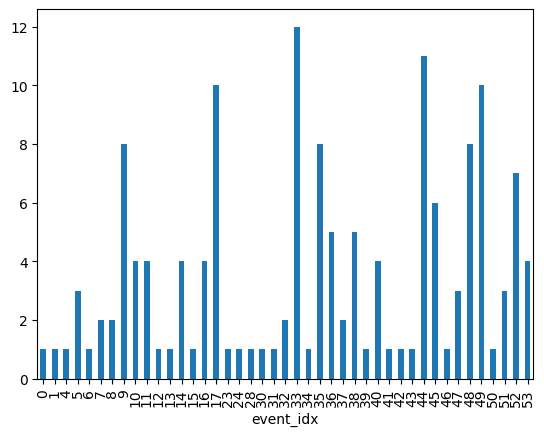

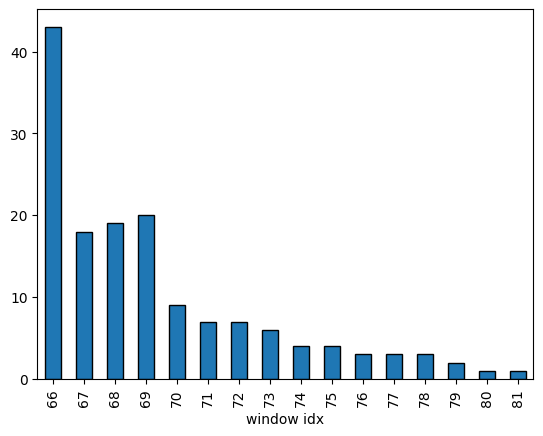

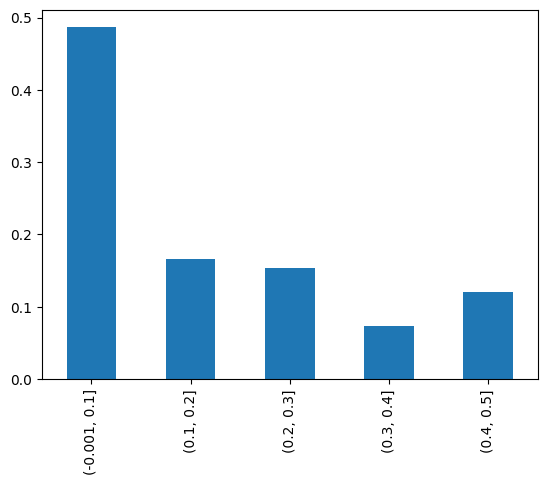

In [180]:
# df and plots settings
pd.set_option("display.float_format", "{:.2%}".format)

pd.options.plotting.backend = "matplotlib"


# print(dataset_df)
pd.set_option("display.max_rows", 2000)
false_positive = dataset_df.query('Result == "FP"')
false_negative = dataset_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])

false_positive_plot = false_positive.groupby(["window idx"])["window idx"].count()
false_negative_plot = false_negative.groupby(["window idx"])["window idx"].count()
# print(false_positive['Pred probability'].value_counts(bins=10, sort=False))


if len(false_positive_plot) > 0:
    print("FALSE POSITVES")
    print(false_positive)
    # print(false_positive.groupby(['event_idx'])['event_idx'].count())
    false_positive.groupby(['event_idx'])['event_idx'].count().plot(kind='bar')
    plt.show()
    false_positive_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_positive["Pred probability"].value_counts(
        bins = [i * 0.1 for i in range(5, 11)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()
if len(false_negative_plot) > 0:
    print("FALSE NEGATIVES")
    print(false_negative)
    # print(false_negative.groupby(['event_idx'])['event_idx'].count())
    false_negative.groupby(['event_idx'])['event_idx'].count().plot(kind='bar')
    plt.show()

    false_negative_plot.plot(kind="bar", edgecolor="black")
    plt.show()
    false_negative["Pred probability"].value_counts(
        bins = [i * 0.1 for i in range(6)], sort=False, normalize=True
    ).plot(kind="bar")
    plt.show()




plt.show()


In [181]:
print(conf_matrix_total)
metrics = conf_matrix_metrics(conf_matrix_total)
print_metrics(metrics)
plot_confusion_matrix(metrics)


[3306    0 3564  150 3456]
Total windows:................7020
True Positives:...............3306
False Positives:..............   0
True Negatives:...............3564
False Negatives:.............. 150
Accuracy:.....................  97.9%
True Positive Rate:...........  95.7%
False Positive Rate:..........   0.0%
True Negative Rate:........... 100.0%
Positive Predictive Value:.... 100.0%


##### 7.6. Save Dataframe and Confusion Matrix

In [183]:
dataset_df.to_parquet('parquet_data/ModelR1_currents_df.parquet')
conf_matrix_df = pd.DataFrame(conf_matrix.cpu(), columns = ['TP','FP','TF', 'FN', 'TP + FN'])
conf_matrix_df.to_parquet('parquet_data/ModelR1_currents_CM_df.parquet')
np.save('parquet_data/ModelR1_currents_CM.npy', conf_matrix.cpu())

##### 7.7. Individual Sample Visualization

C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/R1\Fault01_B124_RF100.csv
256
(256, 0)


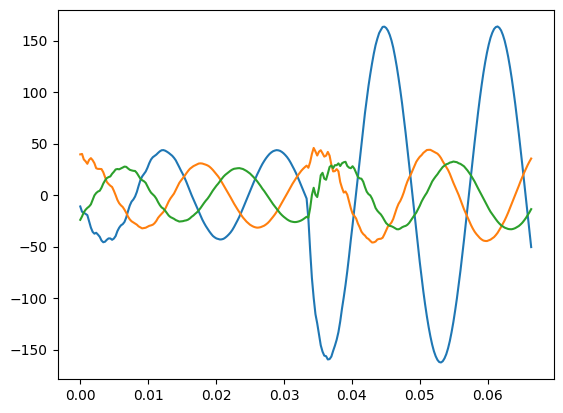

Confusion Matrix: tensor([[63,  0, 66,  1, 64]])
     event_idx  Pred probability  Pred label  True label Result
0            0             2.69%           0           0     TN
1            0             2.98%           0           0     TN
2            0             3.45%           0           0     TN
3            0             4.70%           0           0     TN
4            0             5.64%           0           0     TN
5            0             6.46%           0           0     TN
6            0             6.46%           0           0     TN
7            0             4.61%           0           0     TN
8            0             3.20%           0           0     TN
9            0             2.81%           0           0     TN
10           0             2.93%           0           0     TN
11           0             3.19%           0           0     TN
12           0             3.64%           0           0     TN
13           0             4.45%           0           

FALSE POSITVES
Empty DataFrame
Columns: [event_idx, Pred probability, Pred label, True label, Result]
Index: []

FALSE NEGATIVES
    event_idx  Pred probability  Pred label  True label Result
66          0            43.61%           0           1     FN


In [184]:
# Create signal_df
event_idx = 0
print(dataset.csv_list[event_idx])
sample_df, conf_matrix = signal_exploration(event_idx, dataset, model)
metrics = conf_matrix_metrics(conf_matrix)
print(f"Confusion Matrix: {conf_matrix}")
print(sample_df)
plot_confusion_matrix(metrics)
false_positive = sample_df.query('Result == "FP"')
false_negative = sample_df.query('Result == "FN"')
# sample_df = pd.concat([sample_df, sample_df])
print("FALSE POSITVES")
print(false_positive)
print("")
print("FALSE NEGATIVES")
print(false_negative)

In [195]:
def update_fig(fig):
    fig.update_traces(line_color="#EEEEEE", line_width=2)
    fig.update_layout(
        paper_bgcolor="#222831",
        plot_bgcolor="#393E46",
        font_color="whitesmoke",
    )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="#32E0C4")


signal, t = dataset.__getitem__(2440, data_plot=True)
signal = signal.reshape((-1, 3))
signal = signal[:, 0]
# print(f"Window index: {sample_df.query('indices == 196').index[0]}")
fig = px.line(
    x=t,
    y=signal,
    width=600,
    height=400,
    labels=dict(x="time", y="Amplitude"),
)
# update_fig(fig)
fig.show()
fig = px.line(
    x=sample_df.index,
    y=sample_df["Pred label"],
    width=600,
    height=400,
    labels=dict(x="Window", y="Trip Signal"),
    line_shape="hv",
)
# update_fig(fig)
fig.show()

### 8. References
1. PyTorch Contributors: LSTM. [LSTM — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
<!-- @online{LSTM,
    author = "{PyTorch Contributors}",
    title = "LSTM",
    url  = "https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html",
    addendum = "(accessed: 10.02.2023)",
    keywords = "LSTM pytorch"
} -->